# CalPred model

# Introduction
Polygenic scores (PGS) have emerged as the tool of choice for genomic prediction in personalized medicine. A critical barrier in PGS use is their **context-specific accuracy** – their accuracy varies across genetic ancestry, age, sex, socioeconomic status and other factors. Such context-specific accuracy suggests that two individuals can have the same point predictions with different precisions. We propose an approach (CalPred) to incorporate context-specificity into trait prediction intervals that are allowed to vary across contexts. As an example, consider the case of two individuals with the same PGS-based predictions for low-density lipoprotein cholesterol (LDL) of 120 mg/dL. If the two individuals have different contexts (e.g., sex) that are known to impact PGS accuracy (e.g., $R^2$=0.1 in men vs. 0.2 in women), their prediction intervals will also vary (e.g., 120 ± 40 mg/dL vs. 120 ± 10 mg/dL). In this example the second individual is more likely to meet a decision criterion of LDL>100 mg/dL for clinical intervention.

Formally, we model such prediction intervals using the following approaches by relating each individual's prediction variance to their contexts.
$$ 
y_i \sim \mathcal{N} (\mu(\mathbf{c}_i ),\sigma^2 (\mathbf{c}_i )),i=1,…,N
$$
where 
$$
\mu(\mathbf{c}_i)=\mathbf{c}_i^\top \boldsymbol{\beta}_\mu, \sigma^2 (\mathbf{c}_i )=\exp⁡(\mathbf{c}_i^\top\boldsymbol{\beta}_\sigma).
$$

Next we use a toy simulation dataset to discuss each component of CalPred.

# Simulate phenotype with context-specific accuracy
We simulate variable prediction accuracy across genetic ancestry continuum, age and sex. For simplicity, we assume that the point predictions are given, as $\hat{y} \sim \mathcal{N}(0, 1)$, and we simulate phenotypes $y$ with:

$$
y \sim \mathcal{N}\left(
\hat{y}, 
\exp(\beta_{\sigma,0} + 
\beta_{\sigma, \text{ancestry}} \times \text{ancestry} +
\beta_{\sigma, \text{age}} \times \text{age} +
\beta_{\sigma, \text{sex}} \times \text{sex}
) 
\right)
$$
First, we set $\beta_{\sigma,0} = \log (0.7 / 0.3)$ such that the baseline $R^2 = 0.3$ to control the baseline accuracy. Then we set $\beta_{\sigma, \text{ancestry}} = 0.15, \beta_{\sigma, \text{age}} = 0.25, \beta_{\sigma, \text{sex}} = 0.2$ (these effects are with regard to each standard deviation of context variable).

In [105]:
devtools::load_all(".")

suppressPackageStartupMessages(library(dplyr))
library(ggplot2); theme_set(theme_classic(base_size=14))
library(patchwork)
options(repr.plot.res = 200)

ℹ Loading calpred


In [106]:
n_indiv <- 50000

set.seed(1234)

sd_coef <- c(intercept = log(7 / 3),
             ancestry = 0.2,
             age = -0.15,
             sex = 0.2)
data <- simulate_example(n=n_indiv, sd_coef=sd_coef)

data <- data %>% mutate(
    ancestry_label = cut_number(ancestry, 5, labels = FALSE),
    age_label = cut_number(age, 5, labels = FALSE),
    sex_label = ifelse(sex > 0, "Female", "Male")
)

# Visualizing context-specific accuracy

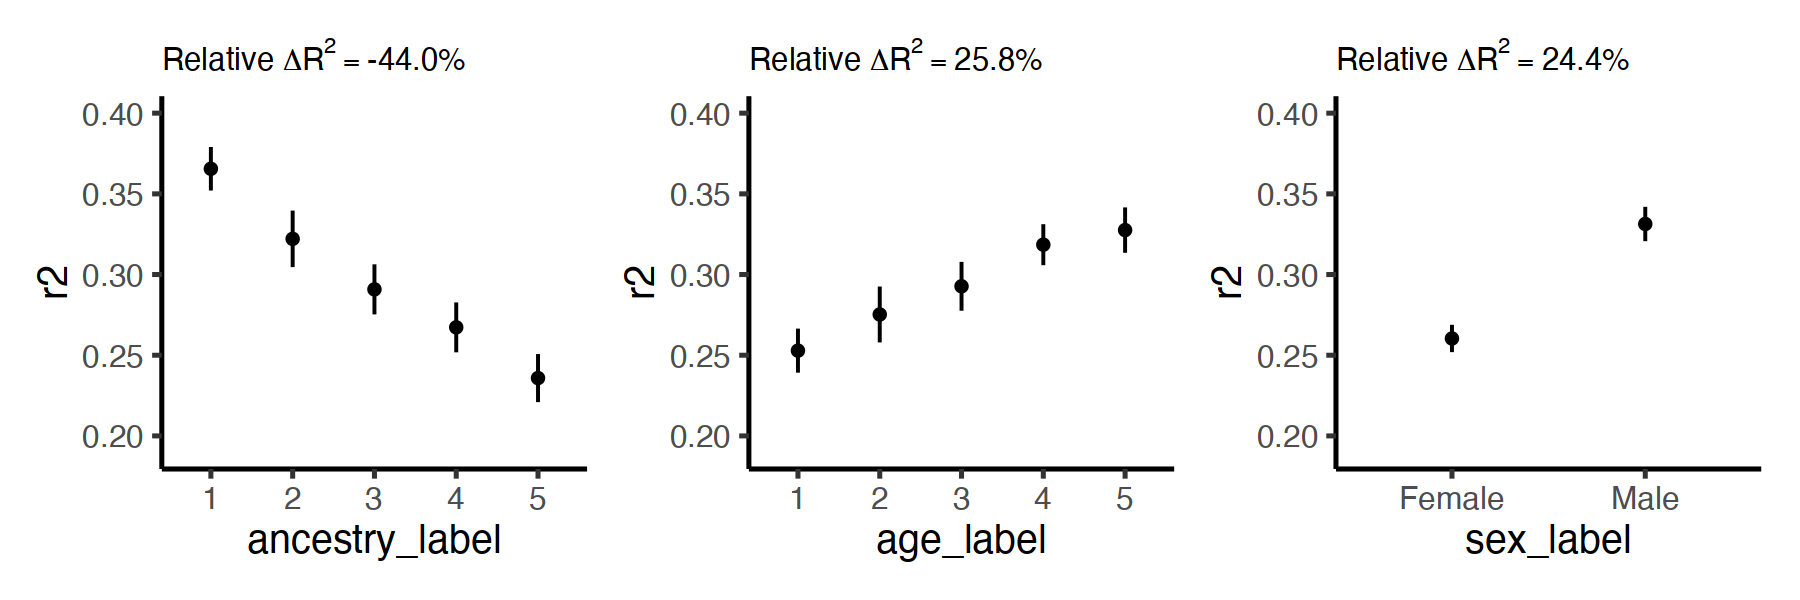

In [107]:
plot_list <- list()

for (context in c("ancestry_label", "age_label", "sex_label")) {
    
    stats <- compute_stats(y=data[, 'y'], pred=data[, 'yhat'], group=data[, context])
    group_r2 <- stats$stats$r2
    # (last group R2 - first group R2) / mean(R2)
    relative_delta_r2 <- (group_r2[length(group_r2)] - group_r2[1]) / mean(group_r2)
    relative_delta_r2 <- sprintf("%0.1f%%", relative_delta_r2 * 100)
    
    p <- plot_stats(stats$bootstrap_stats, 'r2') + 
          labs(title = context, x=context) +
          ylim(0.19, 0.4) + ggtitle(bquote("Relative " * Delta*R^2 == .(relative_delta_r2))) +
          theme(plot.title = element_text(size = 11))
    plot_list[[context]] <- p
}

options(repr.plot.width = 9, repr.plot.height = 3)
wrap_plots(plotlist = plot_list, ncol = 3)

# Fit CalPred model

In [127]:
data$y_bin <- as.integer(data$y > 0)

In [112]:
mean_mat <- as.matrix(data[, c("intercept", "yhat")])
sd_mat <- as.matrix(data[, c("intercept", "ancestry", "age", "sex")])

# fitting context-specific prediction intervals leveraging context information in the data
fit <- train(mean_mat=mean_mat, sd_mat=sd_mat, y=data[, "y"])
pred <- predict(
    mean_mat=mean_mat, 
    sd_mat=sd_mat, 
    mean_coef=fit$mean_coef, 
    sd_coef=fit$sd_coef
)

# Quality of parameter fit
We first check the quality of parameter fit and observe a high consistency between fitted coefficients `fit$sd_coef` and true coefficients `sd_coef`  

In [5]:
fit

$mean_coef
  intercept        yhat 
0.004786026 1.000371241 

$mean_se
  intercept        yhat 
0.006650789 0.006657625 

$sd_coef
 intercept   ancestry        age        sex 
 0.8440848  0.2009975 -0.1356516  0.2023157 

$sd_se
  intercept    ancestry         age         sex 
0.006324682 0.006325526 0.006324947 0.006325552

In [6]:
sd_coef

intercept   ancestry        age        sex 
 0.8472979  0.2000000 -0.1500000  0.2000000

# Check for calibration

In [7]:
mean_mat <- as.matrix(data[, c("intercept", "yhat")])
sd_mat <- as.matrix(data[, c("intercept"), drop=FALSE])

# fitting generic prediction intervals ignoring context information
generic_fit <- train(
    mean_mat=mean_mat, 
    sd_mat=sd_mat, 
    y=data[, "y"]
)
generic_pred <- predict(
    mean_mat=mean_mat, 
    sd_mat=sd_mat, 
    mean_coef=generic_fit$mean_coef, 
    sd_coef=generic_fit$sd_coef
)

We observe that context-specific prediction intervals are calibrated across contexts, as it accounts for the variable accuracy by adjusting interval length as a function of contexts. 

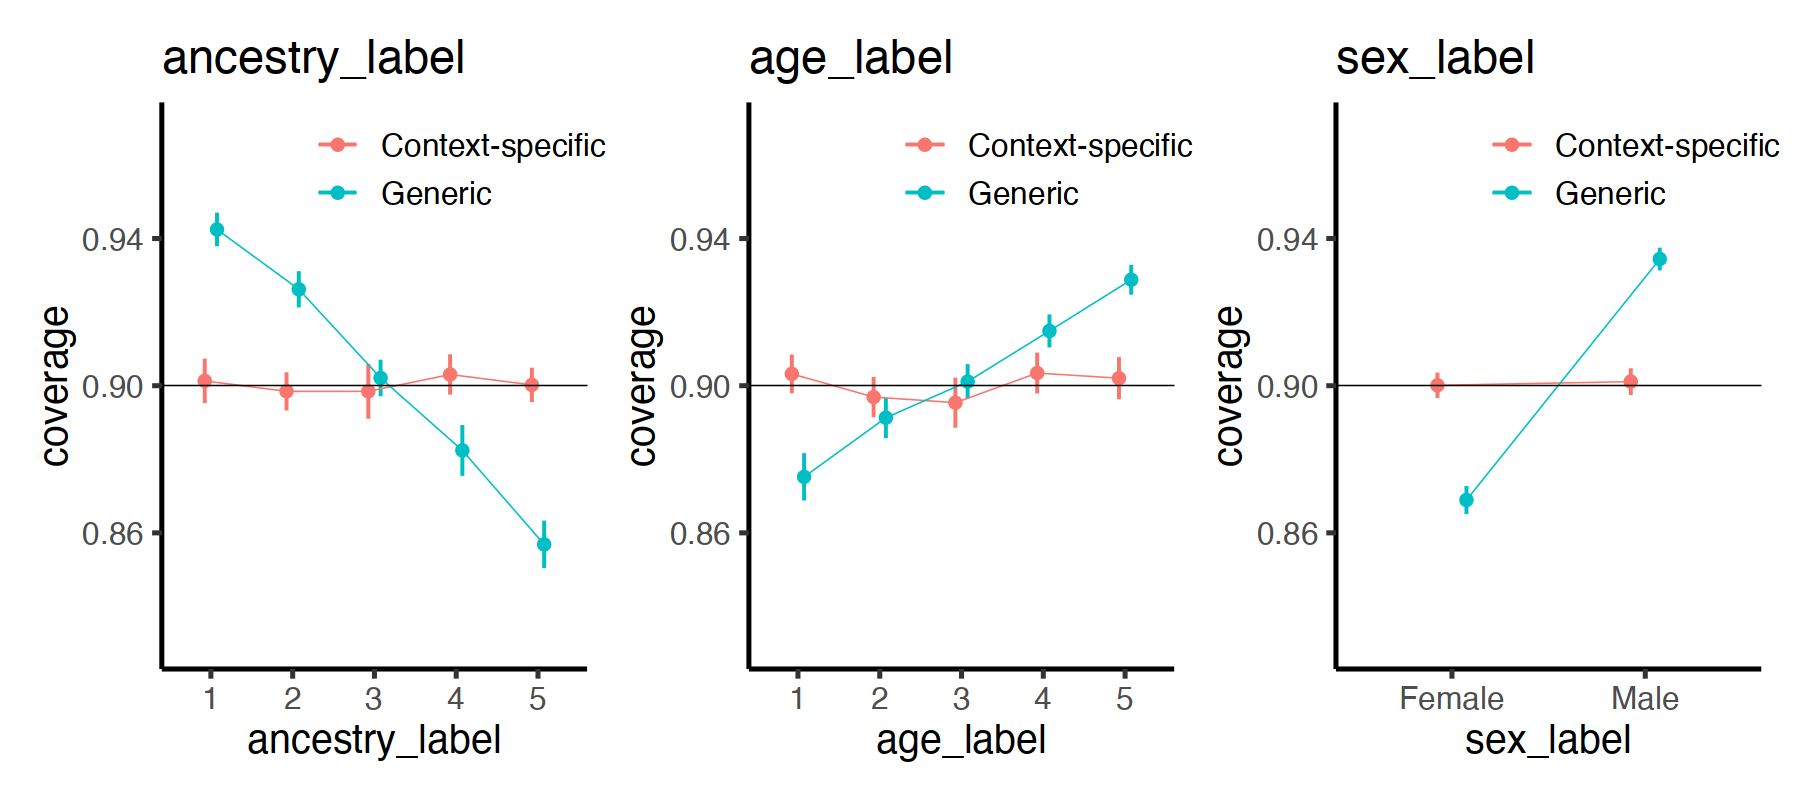

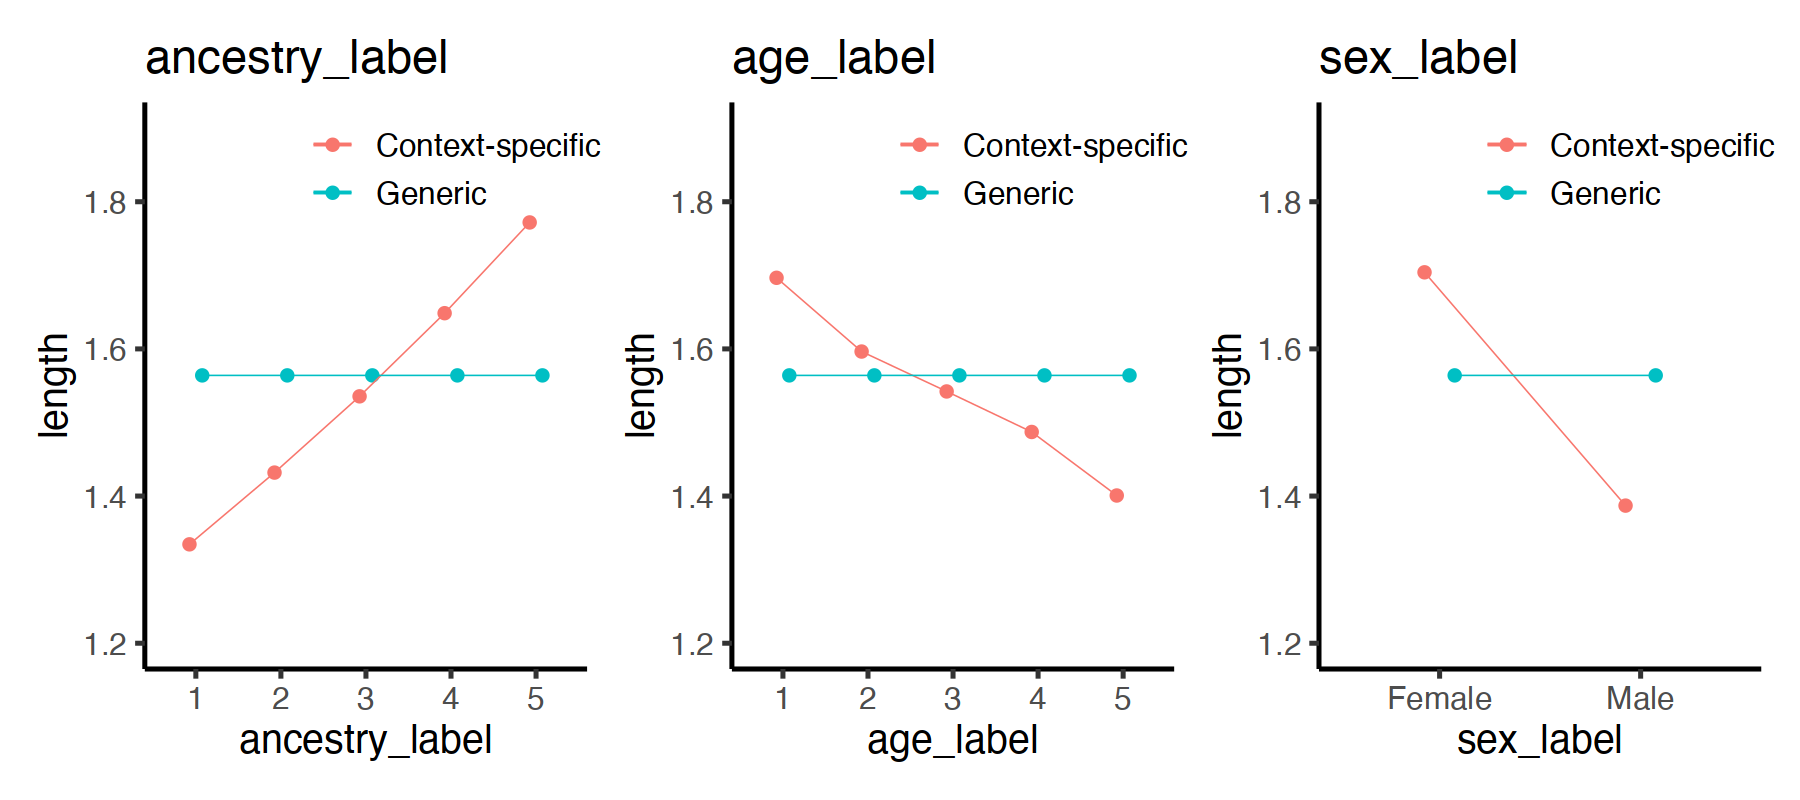

In [8]:
coverage_plots <- list()
length_plots <- list()
for (context in c("ancestry_label", "age_label", "sex_label")) {
        
    stats <- compute_stats(y=data[, 'y'], pred=data[, 'yhat'], predsd=pred$sd, group=data[, context])
    generic_stats <- compute_stats(y=data[, 'y'], pred=data[, 'yhat'], predsd=generic_pred$sd, group=data[, context])
    stats_list <- list(
        `Generic`=generic_stats$bootstrap_stats, 
        `Context-specific`=stats$bootstrap_stats
    )
    
    coverage_plots[[context]] <- plot_stats(stats_list, 'coverage') + 
          labs(title = context, x=context) +
          ylim(0.83, 0.97) + geom_hline(yintercept=0.9, color = "black", linewidth=0.2)
    
    length_plots[[context]] <- plot_stats(stats_list, 'length') + 
          labs(title = context, x=context) + ylim(1.2, 1.9)
    
}
options(repr.plot.width = 9, repr.plot.height = 4)
wrap_plots(coverage_plots, ncol = 3)
wrap_plots(length_plots, ncol = 3)